# Loads the processed h5 file and plots data

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *
from analysis import *
from pedestals import *
from h5_handling import *

In [2]:
# input parameters
temperature = {
              '08 mm' : (250.  + 252.)  / 2,
              '20 mm' : (238.3 + 239.9) / 2,
              '28 mm' : (234.7 + 236.3) / 2,
              '35 mm' : (232.6 + 234.1) / 2,
              '40 mm' : (231.4 + 232.8) / 2,
              '45 mm' : (231.9 + 230.4) / 2,
              '50 mm' : (230.8 + 229.5) / 2,
              '55 mm' : (228.7 + 230)   / 2,
              '60 mm' : (228   + 229.3) / 2,
              '65 mm' : (227.4 + 228.6) / 2,
              '70 mm' : (226.8 + 228.1) / 2,
              '75 mm' : (226.3 + 227.5) / 2,
              '80 mm' : (225.8 + 227)   / 2,
              '85 mm' : (225.4 + 226.6) / 2}

    
run_groups = {
#              '08 mm' : [200],
#              '20 mm' : [196],
              '28 mm' : [109, 110, 111, 113],
              '35 mm' : [115,116,119,121,122,123],
              '40 mm' : [124,125,126],
              '45 mm' : [127,128,129,131,179,180,181],
              '50 mm' : [133,134,135,136,137,182,183],
              '55 mm' : [138,139,140,141,142,143],
              '60 mm' : [145,146,147,149],
              '65 mm' : [150,151,152,153,154,155,156,214],
              '70 mm' : [157,158,159,160,161,162,177,178,201,202,203,204],
              '75 mm' : [165,166,167,168,169,170,184,185,186,187,188,189,190,191,192,193,194,195],
              '80 mm' : [171,172,173,205,206,207,208,209,210,211,212,213],
              '85 mm' : [174,175,176]}    



### load and analyse data

In [3]:
def analyse_run(run_num, detector_distance = 0.1249, energy = 9.5, iq_thr = 1.):
    '''
    loads and analyses a single run
    '''
    
    # load data
    try:
        run_path = '/sf/bernina/data/p17743/res/work/hdf5/'
        run = discover_run_h5(run_num, path=run_path)[3:-3]
        img,Iq,r,nshots,img_hits,thr,nhits,i0,laser_i0,laser_on,event_ID = load_processed_data(run, path=run_path)
    except (OSError, KeyError) as e:
        print(e)
        return None
    
    # convert q_scale
    q = q_scale(r, detector_distance=detector_distance, photon_energy=energy*1000.0)

    # convert intensity to photon/pix
    Iq /=energy
    i0 /=energy

    # normalise to i0
    Iq_norm = np.zeros(Iq.shape)
    i0_avg = np.average(i0)
    norm = i0/i0_avg
    for i in range(int(nshots)):
        Iq_norm[i]=Iq[i]/norm[i]

    # find hits
    metric,hits = find_hits(Iq_norm,threshold=iq_thr,r_min=200,r_max=400)
    
    #find ice
    filter_length = 1       # 1 = filter off
    ice_thr       = 1.           # delta photon/pix/i0
    q_min, q_max  = 1.0, 4.5 # A-1
    ice_metric, ice_hits = find_ice(Iq_norm, q, threshold=ice_thr, 
                                    filter_length=filter_length, q_min=q_min, q_max=q_max)
    # exclude ice hits
    hits *= np.logical_not(ice_hits)
    
    # weak hit rejection
    misses = np.logical_not(hits) & (i0[:nshots] > i0_avg - 2*i0[:nshots].std()) # remove weak x-ray shots (2 std)
    hits = hits & (i0[:nshots] > i0_avg - 2*i0[:nshots].std()) # remove weak x-ray shots (2 std)
    
    # laser rejection
    #l = laser_i0[laser_on.astype(np.bool)][:nshots]
    #laser_outliers = laser_on.astype(np.bool) & ((laser_i0 > (l.mean() + l.std())) | (laser_i0 < (l.mean() - l.std())))
    #hits *= np.logical_not(laser_outliers)
    
    # water hitrate
    hit_rate =len(hits[hits>0])/nshots
    
    # subtract background
    Iq_corr = subtract_background(Iq,hits,i0,nshots)
    
    # hits and miss averages
    hit_avg = np.average(Iq_corr,axis=0)
    miss_avg = np.average(Iq[hits],axis=0) - np.average(Iq_corr,axis=0)

    # pump probe (new method)
    diff_signal = pump_probe_signal_2(Iq_corr,hits,laser_on,r_min=200,r_max=400)
    
    # pump probe
    #hit_avg, miss_avg, diff_signal = pump_probe_signal(Iq, hits, laser_on, 
    #                                                       misses=misses, r_min=200, r_max=400)

    return (q, hit_avg, miss_avg, diff_signal, 
            hit_rate, hits.sum(), (hits & laser_on).sum(), ice_hits.sum(), 
            nshots)



In [4]:
# compute the mean for each run

run_means = {}

for rg in run_groups.keys():
    print(rg)
    runs = run_groups[rg]
    
    run_data = []
    for run in runs:
        #print('--', run)
        data = analyse_run(run)
        if data != None:
            run_data.append(data)
        
    # comprehend this list
    n_data_fields = len(run_data[0]) # should be the same for all
    run_means[rg] = [ np.mean([x[i] for x in run_data], axis=0) for i in range(n_data_fields)]
    
    #if rg == '35 mm': break

28 mm
run0109_droplets_10um_28mm: 18000 shots
(235, 1000)
run0110_droplets_10um_28mm: 17998 shots
(171, 1000)
run0111_droplets_10um_28mm: 17998 shots
(180, 1000)
run0113_droplets_10um_28mm: 17998 shots
(190, 1000)
35 mm
run0115_droplets_10um_35mm: 17998 shots
(140, 1000)
run0116_droplets_10um_35mm: 17998 shots
(130, 1000)
run0119_droplets_10um_35mm: 17998 shots
(161, 1000)
run0121_droplets_10um_35mm: 17998 shots
(136, 1000)
run0122_droplets_10um_35mm: 17998 shots
(148, 1000)
run0123_droplets_10um_35mm: 17998 shots
(129, 1000)
40 mm
run0124_droplets_10um_35mm: 17998 shots
(100, 1000)
run0125_droplets_10um_40mm: 17998 shots
(89, 1000)
run0126_droplets_10um_40mm: 17998 shots
(96, 1000)
45 mm
run0127_droplets_10um_45mm: 17998 shots
(48, 1000)
run0128_droplets_10um_45mm: 17998 shots
(50, 1000)
run0129_droplets_10um_45mm: 17998 shots
(33, 1000)
run0131_droplets_10um_45mm: 17998 shots
(65, 1000)
run0179_droplets_10um_45mm: 17998 shots
(89, 1000)
run0180_droplets_10um_45mm: 17998 shots
(97, 10

/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/sf/bernina/anaconda/4.4.0/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(17998, 1000)
run0172_droplets_10um_80mm: 17998 shots
(17998, 1000)
run0173_droplets_10um_80mm: 17998 shots
(1, 1000)
run0205_droplets_10um_80mm: 18000 shots
(1, 1000)
run0206_droplets_10um_80mm: 18000 shots
(18000, 1000)
run0207_droplets_10um_80mm: 18000 shots
(1, 1000)
run0208_droplets_10um_80mm: 17998 shots
(1, 1000)
run0209_droplets_10um_80mm: 18000 shots
(18000, 1000)
run0210_droplets_10um_80mm: 18000 shots
(1, 1000)
run0211_droplets_10um_80mm: 18000 shots
(18000, 1000)
run0212_droplets_10um_80mm: 17998 shots
(1, 1000)
run0213_droplets_10um_80mm: 18000 shots
(1, 1000)
85 mm
run0174_droplets_10um_85mm: 17998 shots
(17998, 1000)
run0175_droplets_10um_85mm: 17998 shots
(17998, 1000)
run0176_droplets_10um_85mm: 17998 shots
(3, 1000)


### plot

In [11]:
#these ones dont look too good right now
#ez = run_means.pop('80 mm')
#ef = run_means.pop('85 mm')

<IPython.core.display.Javascript object>


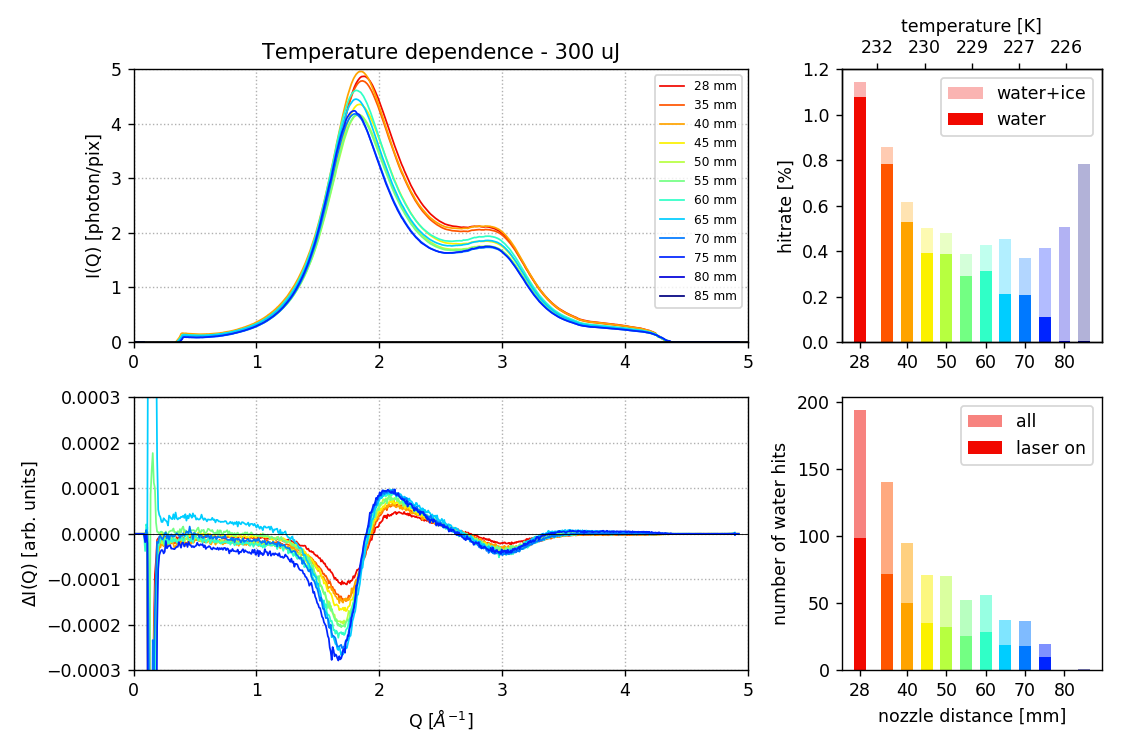

[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]
[(1000,), (1000,), (1000,), (1000,), (), (), (), (), ()]


In [14]:
col = plt.cm.jet(np.linspace(0., 0.9, len(run_means.keys())))[::-1]

plt.figure(figsize=[9,6])

plt.subplot2grid((2,3),(0,0),colspan=2)
plt.title('Temperature dependence - 300 uJ')
for n,rg in enumerate(run_means.keys()):
    print([x.shape for x in run_means[rg]])
    q = run_means[rg][0]
    hit  = run_means[rg][1]
    miss = run_means[rg][2]
    plt.plot(q, hit-miss, label=rg, lw=1, color=col[n])
    #plt.plot(q, hit, label=rg, lw=1, color=col[n],ls='--')
plt.ylabel('I(Q) [photon/pix]')
plt.legend(loc='upper right',fontsize=7)
plt.axhline(0,c='black',lw=1)
plt.xlim(0,5)
plt.ylim(0,5)
plt.grid(linestyle='dotted')

plt.subplot2grid((2,3),(1,0),colspan=2)
for n,rg in enumerate(run_means.keys()):
    plt.plot(q, run_means[rg][3], label=rg, lw=1, color=col[n])
plt.ylabel('$\Delta$I(Q) [arb. units]')
plt.xlabel('Q [$\AA^{-1}$]')
#plt.legend(loc='upper right',fontsize=6)
plt.xlim(0,5)
plt.ylim(-3e-4, 3e-4)
plt.grid(linestyle='dotted')
plt.axhline(0,c='black',lw=0.5)

plt.subplot2grid((2,3),(0,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), (run_means[rg][5]+run_means[rg][7])*100./run_means[rg][8], width=3, alpha=0.3, color=col[n])
    plt.bar(int(rg[:2]), run_means[rg][4]*100, width=3, color=col[n])
plt.legend(['water+ice', 'water'])
plt.ylabel('hitrate [%]')
#plt.xlabel('nozzle distance [mm]')
d = [int(rg[:2]) for rg in run_means.keys()]
ax1 = plt.gca()
ax1.xaxis.set_ticks(d[::2])

T = ["%.0f" % temperature[rg] for rg in run_means.keys()]
ax2 = ax1.twiny()  # instantiate a second axes that shares the same y-axis
plt.locator_params(axis='x', nbins=len(T[::2]))
ax2.xaxis.set_major_formatter(plt.FixedFormatter(T[::2]))
ax2.set_xlabel('temperature [K]')

plt.subplot2grid((2,3),(1,2))
for n,rg in enumerate(run_means.keys()):
    plt.bar(int(rg[:2]), run_means[rg][5], width=3, alpha=0.5, color=col[n])
    plt.bar(int(rg[:2]), run_means[rg][6], width=3, color=col[n])
plt.legend(['all', 'laser on'])
plt.ylabel('number of water hits')
plt.xlabel('nozzle distance [mm]')
ax1 = plt.gca()
ax1.xaxis.set_ticks(d[::2])


plt.tight_layout()
plt.savefig('master_plot_diff_signal_cleaned.png')
plt.show()